In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Load Images

In [2]:
# Setup for image loader
batch_size = 32
img_height = 255
img_width = 255

# Train dataset
train_ds = keras.utils.image_dataset_from_directory(
    directory="dataset_ori",
    validation_split=0.2,
    subset="training",
    seed=123, 
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

Found 6400 files belonging to 2 classes.
Using 5120 files for training.


In [3]:
# Validation dataset
val_ds = keras.utils.image_dataset_from_directory(
    directory="dataset_ori",
    validation_split=0.2,
    subset="validation",
    seed=123, 
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

Found 6400 files belonging to 2 classes.
Using 1280 files for validation.


In [4]:
# Test dataset
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [5]:
# Check for image labels
class_names = train_ds.class_names
print(class_names)

['neutral', 'porn']


Check for images preview. **NSFW WARNING!!**

In [6]:
# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(12):
#     ax = plt.subplot(3, 4, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

# Configure Performance

 - Dataset.cache: This function stores images in memory after they've been initially loaded from disk during the first training epoch. This approach prevents the dataset from slowing down your model training process. Additionally, if your dataset is too large to fit entirely into memory, you can utilize this method to establish an efficient on-disk cache.
 
 - Dataset.prefetch: This function optimizes your workflow by running data preprocessing and model execution in parallel during training. This parallelism further enhances the training efficiency.

In [7]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Rescale Images

In [8]:
# Normalization technique
def normal(image, label):
    image = tf.cast(image/255, tf.float32)
    return image, label

train_ds = train_ds.map(normal)
val_ds = val_ds.map(normal)
test_ds = test_ds.map(normal)

# Define Model

In [9]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu', input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu', input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(128, kernel_size=(3, 3), padding='valid', activation='relu', input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Check model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [11]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
# Train the model
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 386s 2s/step - accuracy: 0.7453 - loss: 3.0321 - val_accuracy: 0.4863 - val_loss: 8.7514
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.7930 - loss: 1.0605 - val_accuracy: 0.6299 - val_loss: 3.0240
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.8457 - loss: 0.5123 - val_accuracy: 0.8301 - val_loss: 0.4957
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.8664 - loss: 0.3910 - val_accuracy: 0.8711 - val_loss: 0.3219
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 386s 2s/step - accuracy: 0.8883 - loss: 0.2710 - val_accuracy: 0.8779 - val_loss: 0.3503
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.9177 - loss: 0.2176 - val_accuracy: 0.8711 - val_loss: 0.3432
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.9270 - loss: 0.1907 - val_accuracy: 0.8652 - val_loss: 0.3646
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.9276 - loss: 0.2134 - val_accu

# Model Evaluation

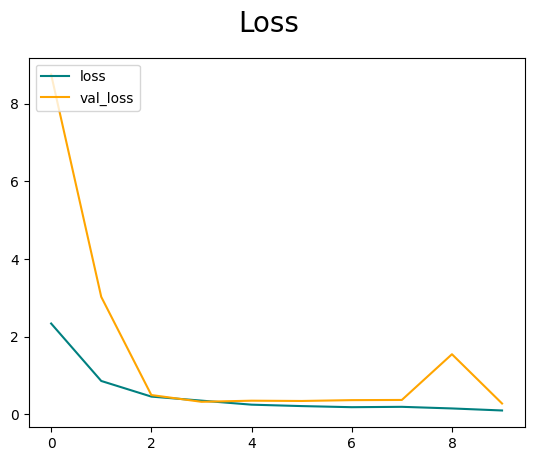

In [14]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

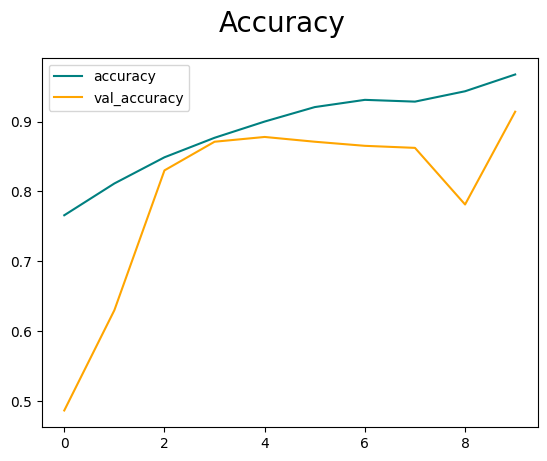

In [15]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [1]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

NameError: name 'model' is not defined